In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Conv1DLayer
from lasagne.layers import MaxPool1DLayer
from lasagne.nonlinearities import softmax
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

from loader import load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 15 seconds


In [4]:
data, features, target = load_data('data.csv')
data.head()

,shot_id,shot_distance,last_moment,away,loc_x,loc_y,type_Alley Oop Dunk Shot,type_Bank Shot,type_Driving Dunk Shot,type_Driving Layup Shot,...,season_2007,season_2008,season_2009,season_2010,season_2011,season_2012,season_2013,season_2014,season_2015,shot_made_flag
0,1,18,False,True,167,72,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2,15,False,True,-157,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,16,False,True,-101,135,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,22,False,True,138,175,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,False,True,0,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
def scale_train_data(data):
    X = data.values.copy()
    np.random.shuffle(X)
    X, labels = X[:, 1:-1].astype(np.float32), X[:, -1]
    encoder = LabelEncoder()
    y = encoder.fit_transform(labels).astype(np.int32)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    print(np.mean(y))
    return X, y, encoder, scaler

def scale_test_data(data, scaler):
    X = data.values.copy()
    X, ids = X[:, 1:].astype(np.float32), X[:, 0].astype(str)
    X = scaler.transform(X)
    return X, ids
    
def make_submission(clf, X_test, ids, name):
    predictions = [i[1] for i in clf.predict_proba(X_test)]
    with open(name, 'w') as f:
        f.write('shot_id,shot_made_flag\n')
        for i, prob in zip(ids, predictions):
            f.write(str(i) + ',' + str(prob) + '\n')
    print('Wrote submission to file {}.'.format(name))

In [10]:
train_data = data[~data['shot_made_flag'].isnull()]
test_data = data[data['shot_made_flag'].isnull()]
test_data.drop(target, axis=1, inplace=True)
X_train, y_train, encoder, scaler = scale_train_data(train_data)
X_test, ids_test = scale_test_data(test_data, scaler)
num_classes = len(encoder.classes_)
num_features = X_train.shape[1]

0.44616103047


In [19]:
class EarlyStopping(object):
    """From https://github.com/dnouri/kfkd-tutorial"""
    def __init__(self, patience=50):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_params = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_train = train_history[-1]['train_loss']
        current_epoch = train_history[-1]['epoch']

        # Ignore if training loss is greater than valid loss
        if current_train > current_valid:
            return

        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_params = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience <= current_epoch:
            print('Early stopping.')
            print('Best valid loss was {:.6f} at epoch {}'.format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_params)
            raise StopIteration()

In [25]:
early_stopping = EarlyStopping(patience=10)

layers0 = [('input', InputLayer),
           ('dense1', DenseLayer),
           ('dropout1', DropoutLayer),
           ('dense2', DenseLayer),
           ('output', DenseLayer)]

net0 = NeuralNet(layers=layers0,
                 
                 input_shape=(None, num_features),
                 dense1_num_units=200,
                 dropout1_p=0.5,
                 dense2_num_units=200,
                 output_num_units=num_classes,
                 output_nonlinearity=softmax,
                 
                 update=nesterov_momentum,
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 
                 on_epoch_finished=[early_stopping],
                 
                 eval_size=0.2,
                 verbose=1,
                 max_epochs=100)

net0.fit(X_train, y_train)

# Neural Network with 61602 learnable parameters

## Layer information

  #  name        size
---  --------  ------
  0  input        104
  1  dense1       200
  2  dropout1     200
  3  dense2       200
  4  output         2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       0.66879       0.62341      1.07280      0.66608  0.41s
      2       0.63695       0.61959      1.02802      0.67085  0.41s
      3       0.62721       0.61465      1.02044      0.67729  0.42s
      4       0.62102       0.61276      1.01348      0.67805  0.39s
      5       0.61657       0.61213      1.00725      0.67824  0.38s
      6       0.61626       0.61252      1.00612      0.67873  0.42s
      7       0.61381       0.61089      1.00477      0.67759  0.41s
      8       0.61099       0.61018      1.00132      0.68205  0.39s
      9       0.61080       0.60987      1.00152      0.68148  0.50s
     10       0.

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f67228836d8>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f67228835c0>,
     check_input=True, custom_scores=None, dense1_num_units=200,
     dense2_num_units=200, dropout1_p=0.5, input_shape=(None, 104),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('dense1', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('dense2', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x7f672288f378>,
     objective_loss_function=<function categorical_crossentropy at 0x7f67228d2620>,
     on_batch_finished=[],
     on_epoch_finished=[<__main__.EarlyStopping object at 0x7f6721d1ca20>, <nolearn.lasagne.handlers.PrintLog object at 0x7f6721d1ca58>],
     on_training

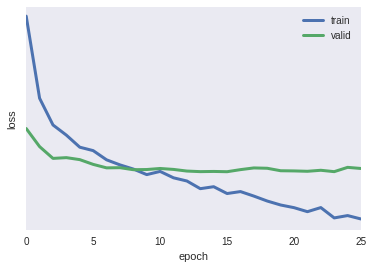

In [13]:
train_loss = np.array([i["train_loss"] for i in net0.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net0.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
lb = min(train_loss.min(), valid_loss.min())
ub = max(train_loss.max(), valid_loss.max())
delta = (ub - lb) / 20
plt.ylim(lb - delta, ub + delta)
plt.yscale("log")
plt.show()